In [5]:
import sys
# extending path to be able to import tudaesasII from the parent directory
sys.path.append('../..')

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 5]
matplotlib.rcParams['lines.linewidth'] = 2
import numpy as np
from numpy import pi
from scipy.linalg import cholesky, eigh, solve
from composites import isotropic_plate

from tudaesasII.quad4r import Quad4R, update_K, update_M, DOF

def mag2db(mag):
    return 20*np.log10(mag)

#NOTE this mesh size might be heavy for your computer
nx = 31
ny = 31

a = 0.4 # [m]
b = 0.4 # [m]

E = 70.e9 # Pa
nu = 0.33
rho = 2.7e3 # kg/m3
h = 0.002 # m

xtmp = np.linspace(0, a, nx)
ytmp = np.linspace(0, b, ny)
xmesh, ymesh = np.meshgrid(xtmp, ytmp)
ncoords = np.vstack((xmesh.T.flatten(), ymesh.T.flatten())).T
x = ncoords[:, 0]
y = ncoords[:, 1]

nids = 1 + np.arange(ncoords.shape[0])
nid_pos = dict(zip(nids, np.arange(len(nids))))
nids_mesh = nids.reshape(nx, ny)
n1s = nids_mesh[:-1, :-1].flatten()
n2s = nids_mesh[1:, :-1].flatten()
n3s = nids_mesh[1:, 1:].flatten()
n4s = nids_mesh[:-1, 1:].flatten()

plate = isotropic_plate(thickness=h, E=E, nu=nu, calc_scf=True)

N = DOF*nx*ny
K = np.zeros((N, N))
M = np.zeros((N, N))
quads = []

for n1, n2, n3, n4 in zip(n1s, n2s, n3s, n4s):
    pos1 = nid_pos[n1]
    pos2 = nid_pos[n2]
    pos3 = nid_pos[n3]
    pos4 = nid_pos[n4]
    r1 = ncoords[pos1]
    r2 = ncoords[pos2]
    r3 = ncoords[pos3]
    normal = np.cross(r2 - r1, r3 - r2)
    assert normal > 0 # guaranteeing that all elements have CCW positive normal
    quad = Quad4R()
    quad.rho = rho
    quad.n1 = n1
    quad.n2 = n2
    quad.n3 = n3
    quad.n4 = n4
    quad.scf13 = plate.scf_k13
    quad.scf23 = plate.scf_k23
    quad.h = h
    quad.ABDE = plate.ABDE
    update_K(quad, nid_pos, ncoords, K)
    update_M(quad, nid_pos, ncoords, M, lumped=False)
    quads.append(quad)

bk = np.zeros(N, dtype=bool) # constrained DOFs, can be used to prescribe displacements
# eliminating u and v
bk[0::DOF] = True
bk[1::DOF] = True
check = np.isclose(x, a/2) & np.isclose(y, b/2)
bk[2::DOF] = check # zero w
bk[3::DOF] = check # zero \phi_x
bk[4::DOF] = check # zero \phi_y

# unknown DOFs
bu = ~bk

# sub-matrices corresponding to unknown DOFs
Kuu = K[bu, :][:, bu]
Muu = M[bu, :][:, bu]
Kuk = K[bu, :][:, bk]
Muk = M[bu, :][:, bk]

L = cholesky(M, lower=True)
Luu = L[bu, :][:, bu]
Luuinv = np.linalg.inv(Luu)
Ktilde = Luuinv @ Kuu @ Luuinv.T

rbmodes = 0
Nmodes = 64
gamma, Vu = eigh(Ktilde, subset_by_index=(0, Nmodes-1)) # already gives V[:, i] normalized to 1
Vu = Vu[:, rbmodes:]
gamma = gamma[rbmodes:]

omegan = gamma**0.5

V = np.zeros((N, Nmodes-rbmodes))
V[bu, :] = Vu

P = V
Pu = Vu

print('omegan [rad/s]', omegan)


omegan [rad/s] [  128.67432651   128.67432651   219.63554831   256.77536962
   375.34916193   686.54820675   686.54829445   893.58456234
  1275.21387512  1275.21535312  1340.6473292   1513.57993572
  1709.73183229  2157.73762636  2157.74303594  2299.10058934
  2612.86895348  2612.87104036  2811.78279233  3025.8054862
  3198.30529355  4041.36795889  4041.38278419  4059.50743623
  4282.20408115  4347.09779899  4347.10409838  4382.54814766
  5099.5707174   5099.64641564  5863.23120553  5914.1970873
  5939.73682424  6081.31534275  6223.18374902  6223.1914375
  6278.01033166  6859.12557147  6972.00019656  7613.73619265
  7613.78858188  8192.34278658  8192.39230841  8596.61781829
  8596.68583087  8598.6952598   8841.92204917  8970.36237533
  9470.18802285  9706.93436546  9787.47207814  9787.81617876
 10683.83862234 10863.9313202  10941.45929212 11450.98938702
 11776.39822991 11776.43266865 11897.84044184 11897.92021453
 12047.81489393 12486.45797868 12726.37840812 12726.78766234]


Direct Frequency Response Analysis (with base excitation)
===
Damping matrix C calculated from modal damping ratio
---

In [6]:
zeta = 0.01
Dm = np.zeros((Nmodes-rbmodes, Nmodes-rbmodes))
Dm[np.diag_indices_from(Dm)] = 2*zeta*omegan
C = L @ P @ Dm @ P.T @ L.T
Cuu = C[bu, :][:, bu]
Cuk = C[bu, :][:, bk]

Sine sweep analysis
---

In [7]:
amplitude = 0.0001
check = np.isclose(x, a/2) | np.isclose(y, b/2)
u = np.zeros(N)
u[2::DOF] = check*amplitude
uk = u[bk]

displs = []
U = np.zeros(K.shape[0], dtype=np.complex128)
omegas = omegan
for omegaf in omegas:
    dukdt = 1j*omegaf*uk
    d2ukdt2 = -omegaf**2*uk
    Fk = - Muk @ d2ukdt2 - Cuk @ dukdt - Kuk @ uk 
    
    # NOTE Direct FRA
    # 1) Calculate the frequency response matrix
    Huu = -Muu*omegaf**2 + Cuu*1j*omegaf + Kuu
    # 2) Solve for the displacement frequency response
    Uu = solve(Huu, Fk)
   
    U[bu] = Uu
    displs.append(U[2::DOF].copy())
displs = np.asarray(displs)
print(omegan[omegan < omegas.max()])
print('ready')


[  128.67432651   128.67432651   219.63554831   256.77536962
   375.34916193   686.54820675   686.54829445   893.58456234
  1275.21387512  1275.21535312  1340.6473292   1513.57993572
  1709.73183229  2157.73762636  2157.74303594  2299.10058934
  2612.86895348  2612.87104036  2811.78279233  3025.8054862
  3198.30529355  4041.36795889  4041.38278419  4059.50743623
  4282.20408115  4347.09779899  4347.10409838  4382.54814766
  5099.5707174   5099.64641564  5863.23120553  5914.1970873
  5939.73682424  6081.31534275  6223.18374902  6223.1914375
  6278.01033166  6859.12557147  6972.00019656  7613.73619265
  7613.78858188  8192.34278658  8192.39230841  8596.61781829
  8596.68583087  8598.6952598   8841.92204917  8970.36237533
  9470.18802285  9706.93436546  9787.47207814  9787.81617876
 10683.83862234 10863.9313202  10941.45929212 11450.98938702
 11776.39822991 11776.43266865 11897.84044184 11897.92021453
 12047.81489393 12486.45797868 12726.37840812]
ready


Text(0.5, 0, 'Excitation frequency [rad/s]')

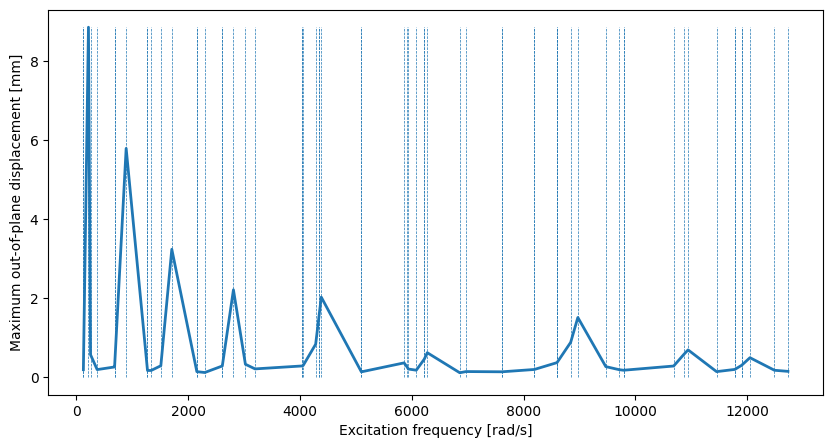

In [8]:
%matplotlib inline
plt.plot(omegas, np.abs(displs).max(axis=1)*1000)
plt.vlines(x=[omegan[omegan < omegas.max()]], ymin=0, ymax=np.abs(displs).max()*1000, ls='--', lw=0.5)
plt.ylabel('Maximum out-of-plane displacement [mm]')
plt.xlabel('Excitation frequency [rad/s]')

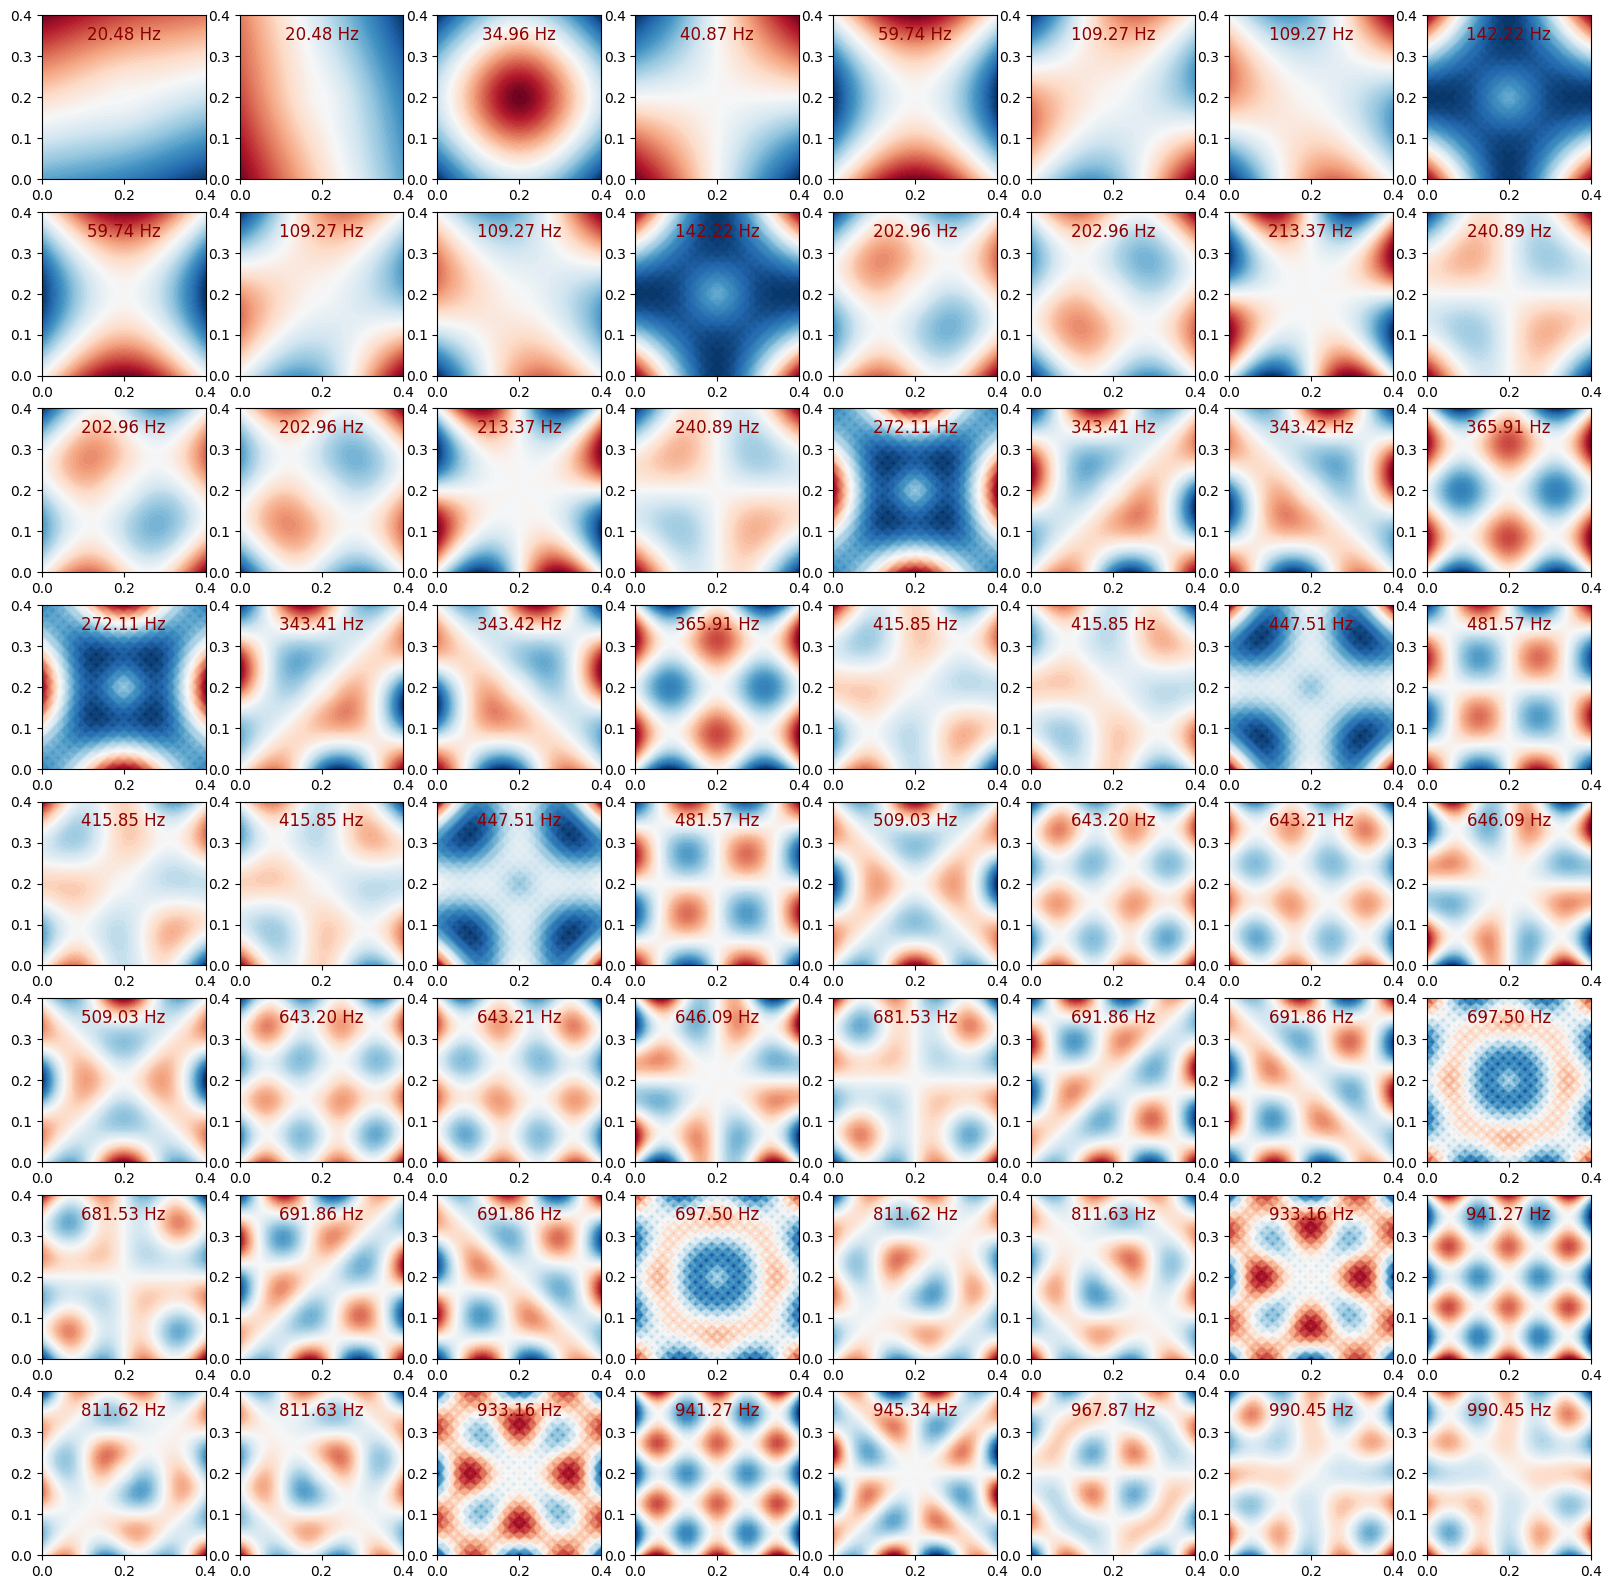

In [9]:
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=[20, 20])
for i in range(8):
    for j in range(8):
        mode = i*4 + j
        Uu = (Luuinv.T @ Vu[:, mode])
        U = np.zeros(K.shape[0])
        U[bu] = Uu
        axes[i, j].contourf(xmesh, ymesh, U[2::DOF].reshape(xmesh.shape).T, levels=100, cmap="RdBu")
        axes[i, j].set_aspect('equal')
        axes[i, j].set_title('%1.2f Hz' % (omegan[mode]/(2*np.pi)), y=0.8, color='darkred')
plt.show()

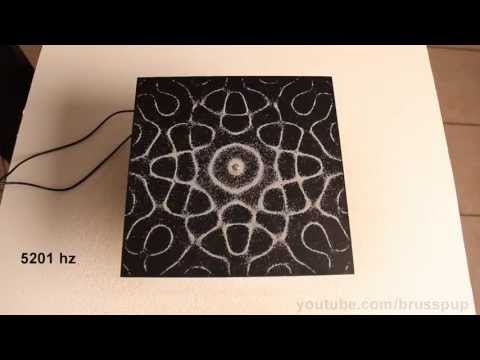

In [10]:
from IPython.display import YouTubeVideo
YouTubeVideo('wvJAgrUBF4w', start=28, allow_autoplay=True, width=900, height=400)